# Why use MGWR?


Based on https://github.com/pysal/mgwr/blob/master/notebooks/MGWR_Georgia_example.ipynb
https://mehak-sachdeva.github.io/MGWR_book/Html/Real_data_example_Poisson-MGWR

## Set up

In [1]:
# Adding necessary libraries to Google Colab environment

# Installing the 'contextily' library for adding basemaps to plots
!pip install contextily -q

# Installing the 'splot' library for spatial data visualization
!pip install splot -q

# Installing additional libraries for spatial analysis and visualization
#!pip install rasterio -q  # Library for reading and writing raster data
#!pip install linearmodels==4.27 -q  # Library for linear models and instrumental variables
!pip install mapclassify -q  # Library for choropleth mapping
#!pip install inequality -q  # Library for measuring economic inequality

# Installing the 'mgwr' library for performing geographically weighted regression
!pip install mgwr -q

!pip install stargazer -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.2/882.2 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.9/389.9 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.7 MB/s eta 0:00:00


In [2]:
# Load libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from pylab import rcParams
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 72

import seaborn as sns
sns.set_style("darkgrid")
sns.set_context(context="paper", font_scale=1.5, rc=None)
sns.set(font="serif")

import plotly.express as px
import plotly.graph_objects as go

import geopandas as gpd


import libpysal as ps
from libpysal  import weights
from libpysal.weights import Queen

import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster, plot_local_autocorrelation
from splot.libpysal import plot_spatial_weights

from giddy.directional import Rose

import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer, LineLocation

from spreg import OLS
from spreg import MoranRes
from spreg import ML_Lag
from spreg import ML_Error

from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap

from spglm.family import Poisson, Binomial,Gaussian

import warnings
warnings.filterwarnings('ignore')
import time

In [114]:


import matplotlib.pyplot as plt
import numpy as np

plt.style.use('default')


plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['font.size'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

## Import Data

In [4]:
import os
os.getcwd()

'/content'

In [5]:
gdf  = gpd.read_file('ward_aggregated_data_100m_poi.geojson')

In [6]:
# get pop density
gdf['POP_density']=gdf['POP']/gdf['Area']




In [7]:
gdf.columns

Index(['Id', 'Area', 'Ward_No', 'POP', 'DENS_PPH', 'NAME', 'assembly', 'jmc',
       'X', 'Y', 'lon', 'lat', 'illum_vol_density', 'light_intensity',
       'poi_kde', 'poi_kde_scaled', 'geometry', 'POP_density'],
      dtype='object')

In [8]:
gdf.describe()

,Id,Area,Ward_No,POP,DENS_PPH,jmc,X,Y,lon,lat,illum_vol_density,light_intensity,poi_kde,poi_kde_scaled,POP_density
count,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,2.510000e+02,251.000000,251.000000,251.000000,251.000000,2.510000e+02,251.000000,251.000000
mean,126.000000,159.354582,65.545817,12166.964143,206.258964,129.880478,579005.408468,2.976127e+06,75.795617,26.904684,102640.800244,32.183418,4.075008e-09,4.075008,208.342580
std,72.601653,196.933140,40.109561,1554.141737,218.552220,24.567980,4137.186715,5.498955e+03,0.041623,0.049671,55628.969448,8.834871,2.968007e-09,2.968007,219.094066
min,1.000000,12.000000,1.000000,8491.000000,0.000000,100.000000,569838.542187,2.963014e+06,75.703277,26.786177,13013.095703,7.748671,1.640855e-10,0.164086,7.637097
25%,63.500000,52.000000,32.000000,11047.000000,64.000000,100.000000,575838.022301,2.972571e+06,75.763574,26.872622,65312.144531,27.538678,1.795912e-09,1.795912,64.639187
50%,126.000000,91.000000,63.000000,12109.000000,136.000000,150.000000,578810.628079,2.977021e+06,75.793901,26.912849,92522.156250,33.067222,3.271182e-09,3.271182,136.558442
75%,188.500000,181.000000,94.000000,13142.500000,241.500000,150.000000,582296.648380,2.980074e+06,75.828761,26.940413,127905.933594,37.940108,5.597422e-09,5.597422,244.132353
max,251.000000,1364.000000,150.000000,16541.000000,1202.000000,150.000000,589472.454442,2.988687e+06,75.900686,27.018317,485380.687500,50.792786,1.308537e-08,13.085366,1202.166667


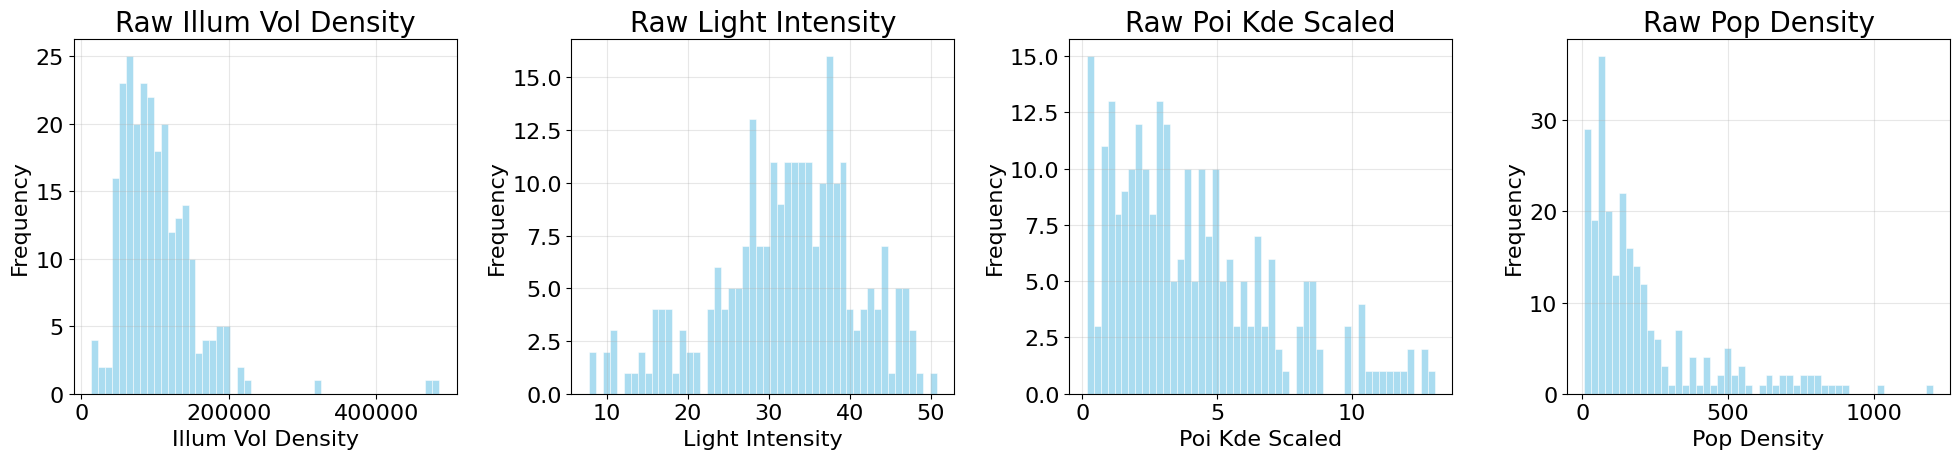

In [79]:
# orginal
check_var_cols = ['illum_vol_density', 'light_intensity', 'poi_kde_scaled', 'POP_density']

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.patch.set_facecolor('white')

for i, col in enumerate(check_var_cols):




    axes[i].set_facecolor('white')

    axes[i].hist(gdf[col], bins=50, alpha=0.7, color='skyblue', edgecolor='white', linewidth=0.5)
    axes[i].set_xlabel(col.replace('_', ' ').title())
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Raw {col.replace("_", " ").title()}')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('mgwr_raw_var.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [10]:
gdf.describe()

,Id,Area,Ward_No,POP,DENS_PPH,jmc,X,Y,lon,lat,illum_vol_density,light_intensity,poi_kde,poi_kde_scaled,POP_density
count,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,2.510000e+02,251.000000,251.000000,251.000000,251.000000,2.510000e+02,251.000000,251.000000
mean,126.000000,159.354582,65.545817,12166.964143,206.258964,129.880478,579005.408468,2.976127e+06,75.795617,26.904684,102640.800244,32.183418,4.075008e-09,4.075008,208.342580
std,72.601653,196.933140,40.109561,1554.141737,218.552220,24.567980,4137.186715,5.498955e+03,0.041623,0.049671,55628.969448,8.834871,2.968007e-09,2.968007,219.094066
min,1.000000,12.000000,1.000000,8491.000000,0.000000,100.000000,569838.542187,2.963014e+06,75.703277,26.786177,13013.095703,7.748671,1.640855e-10,0.164086,7.637097
25%,63.500000,52.000000,32.000000,11047.000000,64.000000,100.000000,575838.022301,2.972571e+06,75.763574,26.872622,65312.144531,27.538678,1.795912e-09,1.795912,64.639187
50%,126.000000,91.000000,63.000000,12109.000000,136.000000,150.000000,578810.628079,2.977021e+06,75.793901,26.912849,92522.156250,33.067222,3.271182e-09,3.271182,136.558442
75%,188.500000,181.000000,94.000000,13142.500000,241.500000,150.000000,582296.648380,2.980074e+06,75.828761,26.940413,127905.933594,37.940108,5.597422e-09,5.597422,244.132353
max,251.000000,1364.000000,150.000000,16541.000000,1202.000000,150.000000,589472.454442,2.988687e+06,75.900686,27.018317,485380.687500,50.792786,1.308537e-08,13.085366,1202.166667


In [11]:
gdf.columns

Index(['Id', 'Area', 'Ward_No', 'POP', 'DENS_PPH', 'NAME', 'assembly', 'jmc',
       'X', 'Y', 'lon', 'lat', 'illum_vol_density', 'light_intensity',
       'poi_kde', 'poi_kde_scaled', 'geometry', 'POP_density'],
      dtype='object')

In [14]:
# raw_Variable

y_col = 'POP_density'
x_cols = ['illum_vol_density', 'light_intensity', 'poi_kde_scaled']

# save params for grid-level estimates
training_params = {
    'y_params': {},
    'x_params': {}
}



y_log = np.log1p(gdf[y_col])


y_mu = y_log.mean()
y_std = y_log.std(ddof=0) 

training_params['y_params'] = {'mu': float(y_mu), 'std': float(y_std)}


gdf[y_col + '_std'] = (y_log - y_mu) / y_std


for col in x_cols:
  
    x_log = np.log1p(gdf[col])

    
    x_mu = x_log.mean()
    x_std = x_log.std(ddof=0)

    training_params['x_params'][col] = {'mu': float(x_mu), 'std': float(x_std)}

    
    gdf[col + '_std'] = (x_log - x_mu) / x_std



from pathlib import Path
import json

Path("model_params").mkdir(exist_ok=True)
with open("model_params/ward_scalers.json", "w", encoding="utf-8") as f:
    json.dump(training_params, f, indent=4) 



In [15]:
gdf.columns

Index(['Id', 'Area', 'Ward_No', 'POP', 'DENS_PPH', 'NAME', 'assembly', 'jmc',
       'X', 'Y', 'lon', 'lat', 'illum_vol_density', 'light_intensity',
       'poi_kde', 'poi_kde_scaled', 'geometry', 'POP_density',
       'POP_density_std', 'illum_vol_density_std', 'light_intensity_std',
       'poi_kde_scaled_std'],
      dtype='object')

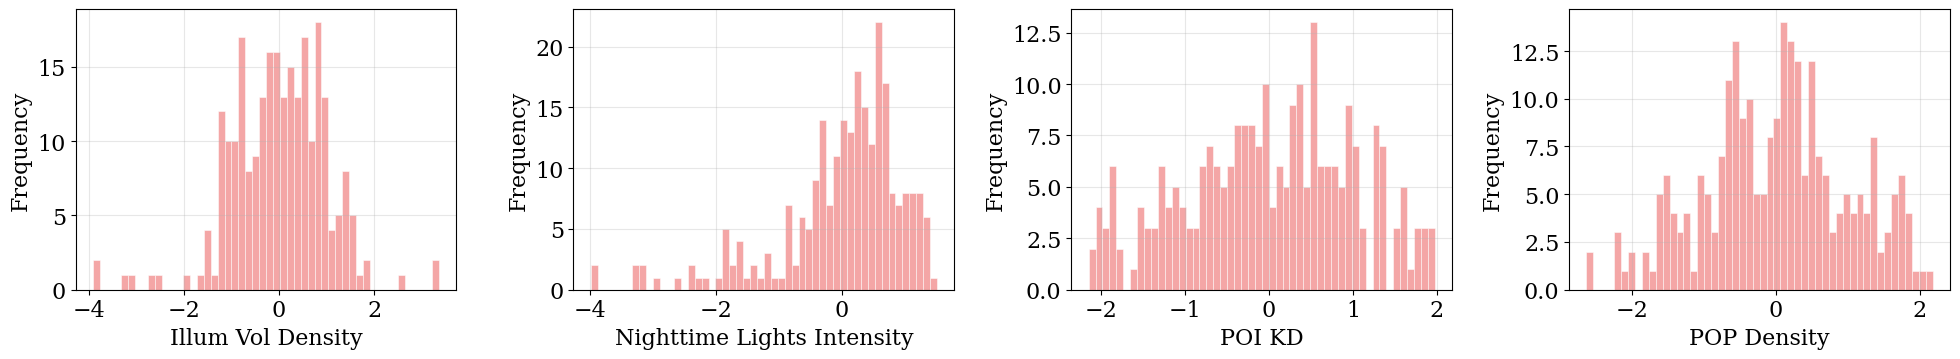

In [115]:
# cols

trans_var_cols = ['illum_vol_density_std', 'light_intensity_std', 'poi_kde_scaled_std', 'POP_density_std']


col_name_map = {
    'illum_vol_density': 'Illum Vol Density',
    'light_intensity': 'Nighttime Lights Intensity',
    'poi_kde_scaled': 'POI KD',
    'POP_density': 'POP Density'
}

fig, axes = plt.subplots(1, 4, figsize=(20, 4))
fig.patch.set_facecolor('white')

for i, col in enumerate(trans_var_cols):
    axes[i].set_facecolor('white')

    axes[i].hist(gdf[col], bins=50, alpha=0.7, color='lightcoral', edgecolor='white', linewidth=0.5)


    base_col = col.replace('_std', '')
    display_name = col_name_map.get(base_col, base_col.replace('_', ' ').title())

    axes[i].set_xlabel(f'{display_name}')
    axes[i].set_ylabel('Frequency')
    #axes[i].set_title(f'Standardized {display_name}')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('mgwr_trans_var.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


In [22]:
gdf.columns

Index(['Id', 'Area', 'Ward_No', 'POP', 'DENS_PPH', 'NAME', 'assembly', 'jmc',
       'X', 'Y', 'lon', 'lat', 'illum_vol_density', 'light_intensity',
       'poi_kde', 'poi_kde_scaled', 'geometry', 'POP_density',
       'POP_density_std', 'illum_vol_density_std', 'light_intensity_std',
       'poi_kde_scaled_std'],
      dtype='object')

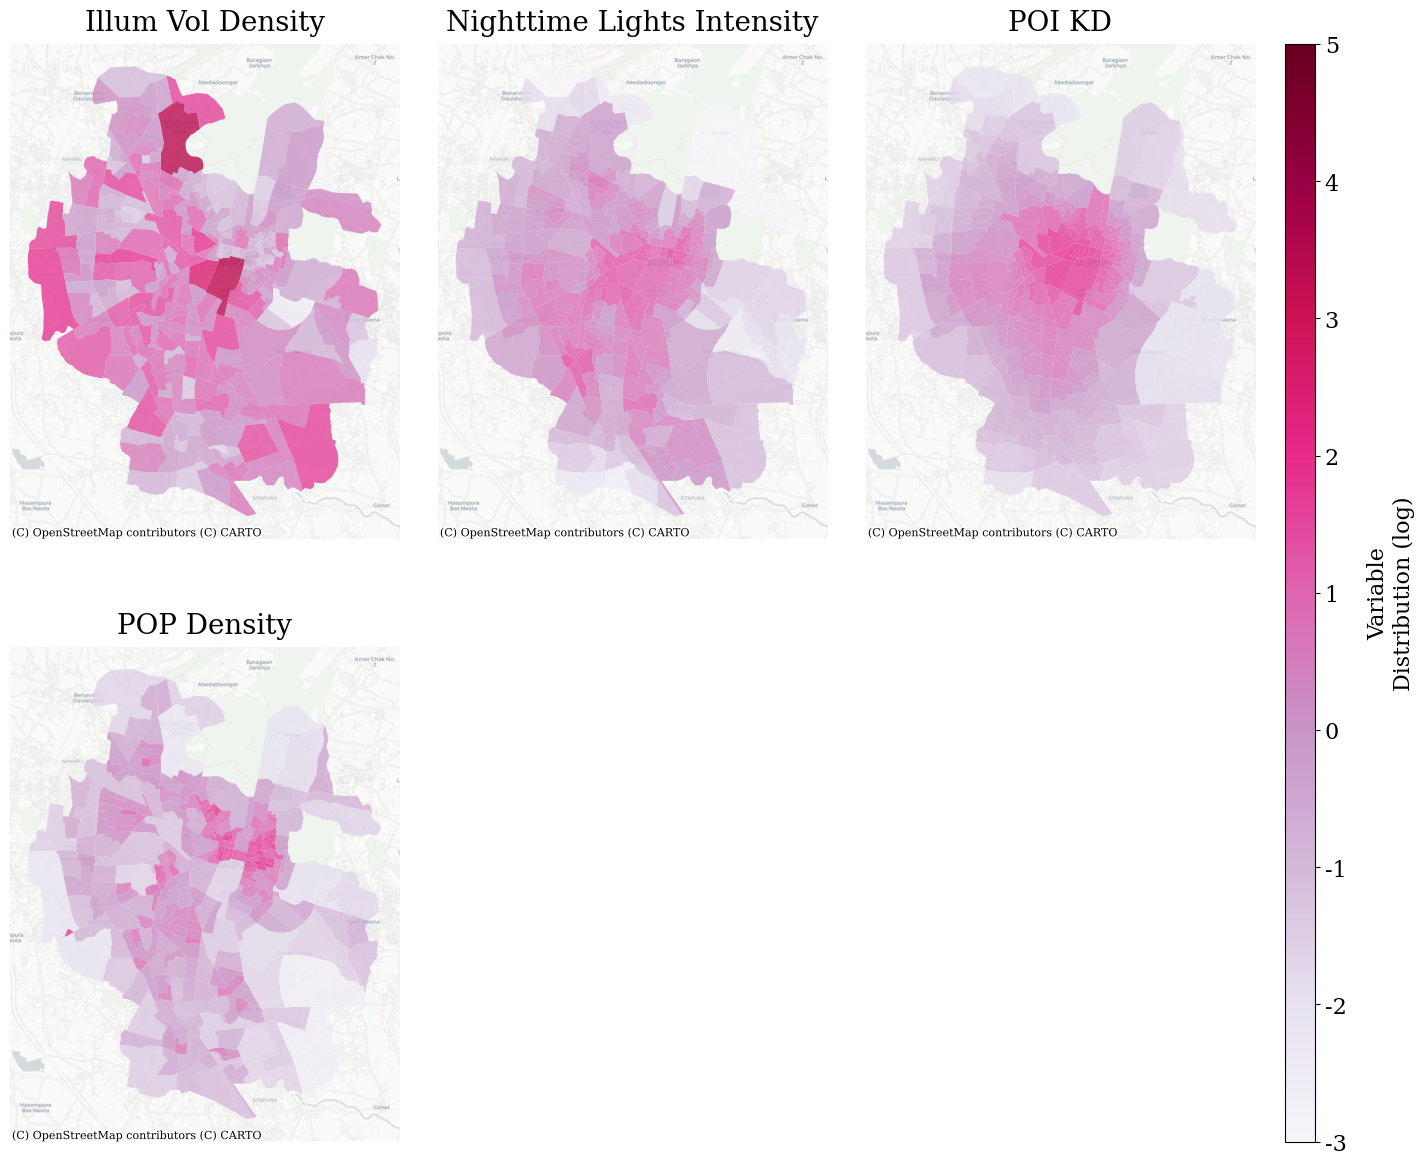

In [116]:
# strandizated var map

import contextily as cx
from matplotlib.colors import Normalize

# Define variables and label mapping
trans_var_cols = ['illum_vol_density_std', 'light_intensity_std', 'poi_kde_scaled_std', 'POP_density_std']
col_name_map = {
    'illum_vol_density_std': 'Illum Vol Density',
    'light_intensity_std': 'Nighttime Lights Intensity',
    'poi_kde_scaled_std': 'POI KD',
    'POP_density_std': 'POP Density'
}

# Create 2x3 subplot layout for all four variables
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 12))

# Define variables (all 4)
trans_var_cols_display = trans_var_cols

# Set fixed color scale range from -3 to +5
vmin, vmax = -3, 5
norm = Normalize(vmin=vmin, vmax=vmax)

# Set colormap to PuRd
cmap = plt.cm.PuRd

# Create map for each variable
for i, col in enumerate(trans_var_cols_display):
    if i < 3:
        # First row
        ax = axes[0, i]
    else:
        # Second row, first position
        ax = axes[1, 0]

    if col in gdf.columns:
        # Ensure GeoDataFrame uses Web Mercator projection
        if gdf.crs != 'EPSG:3857':
            gdf_projected = gdf.to_crs('EPSG:3857')
        else:
            gdf_projected = gdf.copy()

        # Plot geographic data
        gdf_projected.plot(
            column=col,
            ax=ax,
            cmap=cmap,
            norm=norm,
            edgecolor='none',
            alpha=0.8,
            legend=False
        )

        # Add basemap
        try:
            cx.add_basemap(ax,
                          crs=gdf_projected.crs,
                          source=cx.providers.CartoDB.Positron,
                          alpha=1)
        except Exception as e:
            print(f"Unable to add basemap: {e}")

        # Set title
        display_name = col_name_map.get(col, col)
        ax.set_title(display_name, pad=10)

    else:
        # If column doesn't exist, show blank with message
        ax.text(0.5, 0.5, f'Column "{col}" not found',
               ha='center', va='center', transform=ax.transAxes,
               bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
        ax.set_title(col_name_map.get(col, col), pad=10)

    # Remove axis ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Remove subplot borders/spines
    for spine in ax.spines.values():
        spine.set_visible(False)

# Hide the empty subplots (second row, positions 2 and 3)
axes[1, 1].set_visible(False)
axes[1, 2].set_visible(False)

# Adjust layout with smaller spacing between maps
plt.tight_layout()
plt.subplots_adjust(right=0.85, wspace=0.1, hspace=0.2)

# Add shared colorbar on the right side
# Calculate the total height from top of first row to bottom of second row
pos_top = axes[0, 0].get_position()
pos_bottom = axes[1, 0].get_position()
total_height = pos_top.y1 - pos_bottom.y0

cbar_ax = fig.add_axes([0.87, pos_bottom.y0, 0.02, total_height])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.set_label('Variable\nDistribution (log)', rotation=90, labelpad=15)

# Set colorbar ticks for -3 to +5 range
ticks = [-3, -2, -1, 0, 1, 2, 3, 4, 5]
cbar.set_ticks(ticks)
cbar.set_ticklabels([f'{tick}' for tick in ticks])

plt.savefig('mgwr_feature_maps.png', dpi=300, bbox_inches='tight')
plt.show()




In [110]:
import matplotlib.pyplot as plt
print(plt.rcParams['font.sans-serif'])
print(plt.rcParams['font.family'])

['Arial', 'DejaVu Sans', 'Liberation Sans']
['sans-serif']


In [113]:
import matplotlib.font_manager as fm
available_fonts = [f.name for f in fm.fontManager.ttflist]
print('DejaVu Sans' in available_fonts)

True


In [31]:
# ⑦ set up inputs for MGWR
# MGWR dep var
mgwr_y_col = y_col + '_std'
# MGWR explain var
mgwr_x_cols = [col + '_std' for col in x_cols]

## Prepare inputs

In [32]:
g_y = gdf[mgwr_y_col].values.reshape((-1,1))
g_X = gdf[mgwr_x_cols].values
print(g_y.shape)
print(g_X.shape)

(251, 1)
(251, 3)


In [33]:
print("g_y (POP_den):")
print("  Mean:", g_y.mean())
print("  Min:", g_y.min())
print("  Max:", g_y.max())

print("\ng_X (illum_vol_den, light_intensity, poi_kde_scaled):")
print("  Mean:", g_X.mean(axis=0))
print("  Min:", g_X.min(axis=0))
print("  Max:", g_X.max(axis=0))

g_y (POP_den):
  Mean: 2.8308475528290844e-16
  Min: -2.6350318852444787
  Max: 2.1833074715850915

g_X (illum_vol_den, light_intensity, poi_kde_scaled):
  Mean: [-1.93205345e-15 -4.95398322e-16 -3.96318657e-16]
  Min: [-3.91452303 -3.99326582 -2.1512059 ]
  Max: [3.36755076 1.51900631 1.97631049]


In [34]:
# # Standardised our data to have mean of 0 and standard deviation of 1
# g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)


In [35]:
print("Mean of each variable in g_X:", g_X.mean(axis=0))
print("Min of each variable in g_X:", g_X.min(axis=0))
print("Max of each variable in g_X:", g_X.max(axis=0))

Mean of each variable in g_X: [-1.93205345e-15 -4.95398322e-16 -3.96318657e-16]
Min of each variable in g_X: [-3.91452303 -3.99326582 -2.1512059 ]
Max of each variable in g_X: [3.36755076 1.51900631 1.97631049]


In [36]:
u = gdf['X']
v = gdf['Y']
g_coords = list(zip(u,v))

In [37]:
print(g_y.shape)
print(g_X.shape)


(251, 1)
(251, 3)


## Select bandwith use AICc

In [38]:
# Instantiate the bandwidth selection object for MGWR (multi=True)
# This tells the selector to find a different bandwidth for each variable.

mgwr_selector = Sel_BW(g_coords, g_y,g_X,multi=True,spherical=False)

# search() finds the optimal bandwidths.
print("--- Starting Bandwidth Selection .. ---")
mgwr_bw = mgwr_selector.search() # Use AICc as the criterion for stopping

print("--- Bandwidth Selection Complete ---")
print("Optimal Bandwidths:", mgwr_bw)

--- Starting Bandwidth Selection .. ---


Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

--- Bandwidth Selection Complete ---
Optimal Bandwidths: [ 43. 227.  43.  98.]


## Model Fit

In [39]:
res_g = MGWR(g_coords,g_y, g_X, mgwr_selector).fit()
res_g.summary()

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Model type                                                         Gaussian
Number of observations:                                                 251
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             82.219
Log-likelihood:                                                    -216.088
AIC:                                                                440.175
AICc:                                                               442.420
BIC:                                                              -1282.568
R2:                                                                   0.672
Adj. R2:                                                              0.668

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### get summary table output

In [40]:
! pip install openpyxl

In [41]:
import pandas as pd



# --- Step 1: Manually define variable names ---
variable_names = {
    'X0': 'Intercept',
    'X1': 'Illuminated Volume Density',
    'X2': 'Light Intensity',
    'X3': 'POI KDE (scaled)' # Update variable names to reflect scaling
}


# --- Step 2: Build the first table with new values based on your new model output ---

df_table1 = pd.DataFrame({
    'Model Diagnostic': [
        'Adjusted R²',
        'AICc',
        'Residual Sum of Squares (RSS)',
        'Log-Likelihood'
    ],
    'OLS (Global Model)': [
        0.668,      # New result: Adj. R2
        442.420,    # New result: AICc
        82.219,     # New result: Residual sum of squares
        -216.088    # New result: Log-likelihood
    ],
    'MGWR (Multiscale Local Model)': [
        0.789,      # New result: Adj. R2
        364.814,    # New result: AICc
        45.932,     # New result: Residual sum of squares
        -143.019    # New result: Log-likelihood
    ]
})


# --- Step 3: Build the second table with new values based on your new model output ---

table2_data = [
    {
        'Variable': variable_names['X0'], 'Bandwidth': 43, 'Scale of Effect': 'Local',
        'Mean': 0.230, 'STD': 0.322, 'Min': -0.357, 'Max': 0.771
    },
    {
        'Variable': variable_names['X1'], 'Bandwidth': 227, 'Scale of Effect': 'Global',
        'Mean': -0.516, 'STD': 0.013, 'Min': -0.544, 'Max': -0.483
    },
    {
        'Variable': variable_names['X2'], 'Bandwidth': 43, 'Scale of Effect': 'Local',
        'Mean': 0.298, 'STD': 0.273, 'Min': -0.238, 'Max': 1.054
    },
    {
        'Variable': variable_names['X3'], 'Bandwidth': 98, 'Scale of Effect': 'Regional', # 98 can be considered regional scale
        'Mean': 0.192, 'STD': 0.144, 'Min': 0.061, 'Max': 0.545
    }
]

df_table2 = pd.DataFrame(table2_data)


# --- Step 4: Write the two tables to two separate Excel files ---

# Define output filenames
excel_output_path_table1 = 'mgwr_table1_performance.xlsx'
excel_output_path_table2 = 'mgwr_table2_parameters.xlsx'

# Write the first file
df_table1.to_excel(excel_output_path_table1, sheet_name='Model Performance', index=False)
print(f"Successfully created performance comparison table: '{excel_output_path_table1}'")

# Write the second file
df_table2.to_excel(excel_output_path_table2, sheet_name='Parameter Estimates', index=False)
print(f"Successfully created parameter estimates table: '{excel_output_path_table2}'")

Successfully created performance comparison table: 'mgwr_table1_performance.xlsx'
Successfully created parameter estimates table: 'mgwr_table2_parameters.xlsx'


## Check residue saptial auto-correlation

In [42]:
gdf['resid_g'] = res_g.resid_response.flatten()
w = ps.weights.Queen.from_dataframe(gdf)
w.transform = 'r'
mi = Moran(gdf['resid_g'], w)
print(f"Moran's I = {mi.I:.4f}, p-value = {mi.p_norm:.4f}")

Moran's I = 0.0624, p-value = 0.0822


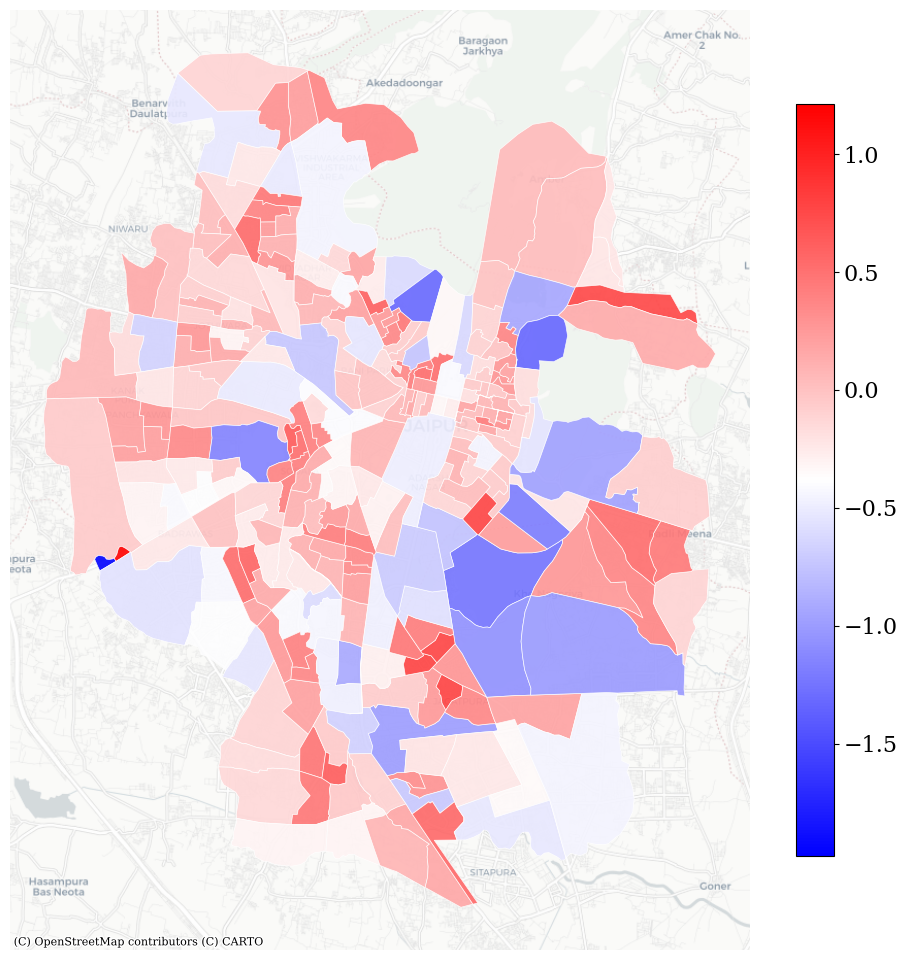

In [117]:
import contextily as cx


fig, ax = plt.subplots(1, 1, figsize=(10, 10))


fig.patch.set_facecolor('white')
ax.set_facecolor('white')

if gdf.crs != 'EPSG:3857':
    gdf_projected = gdf.to_crs('EPSG:3857')
else:
    gdf_projected = gdf.copy()


gdf_projected.plot('resid_g',
                   cmap='bwr',  
                   legend=True,  
                   ax=ax,
                   edgecolor='white',  
                   linewidth=0.5,     
                   alpha=0.9,        
                   legend_kwds={'shrink': 0.8, 'aspect': 20})  


try:
    cx.add_basemap(ax,
                   crs=gdf_projected.crs,
                   source=cx.providers.CartoDB.Positron,
                   alpha=1)  
except Exception as e:
    print(f"Unable to add basemap: {e}")


# ax.set_title('MGWR_gaussian Model Residuals',
#              fontdict={'fontsize': 16, 'fontweight': 'normal'},
#              pad=20)


ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])


for spine in ax.spines.values():
    spine.set_visible(False)


plt.tight_layout()


plt.savefig('residuals_map_gaussian_mgwr.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')

plt.show()

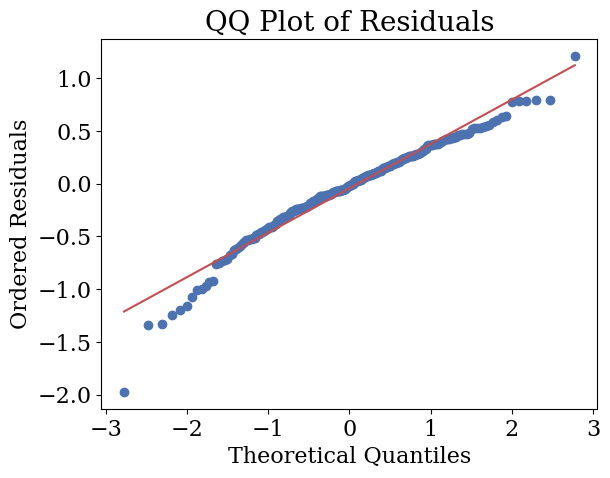

Shapiro-Wilk Test: W = 0.9647, p-value = 0.0000


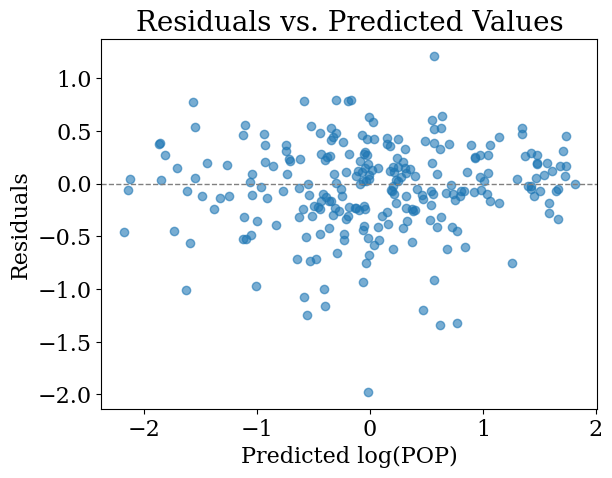

In [118]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import probplot, shapiro




#resid_g = res_g.resid_response.flatten()
gdf['pred_g'] = res_g.predy.flatten()


plt.figure()
probplot(gdf['resid_g'], dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Ordered Residuals")
plt.show()


stat, p_value = shapiro(gdf['resid_g'])
print(f"Shapiro-Wilk Test: W = {stat:.4f}, p-value = {p_value:.4f}")


plt.figure()
plt.scatter(gdf['pred_g'], gdf['resid_g'], alpha=0.6)
plt.axhline(0, color='grey', linewidth=1, linestyle='--')
plt.title("Residuals vs. Predicted Values")
plt.xlabel("Predicted log(POP)")
plt.ylabel("Residuals")
plt.show()

## Bandwidth Search

## AICc and local 𝑅2(Percent deviance explained)

- Model fit can be assessed using global statistics such as the AIC, AICc, or, a pseudo-𝑅2
, which are all available as attributes of the GWRResults object that is returned from a successful model calibration. It is also possible to assess the fit of the model at each calibration location **by mapping a local 𝑅2
 statistic**. This local measure of fit provides an indication of how well the model fits over the smoothed data, focused at each site.

- Figure 6 shows that the individual regression models that comprise the GWR model have model fits that are both larger and smaller than the global 𝑅2
- It is also clear that the variation in model fit is spatially patterned with higher model fit in the east than in the west. Maybe it is fewer data

- Count distributions and the mathematics of the Poisson deviance often create the illusion of “better” local fit in very low-population areas.
At each location the local % deviance-explained is defined as

\text{local %dev} = 1-\frac{Dev}{Dev_0}\

so its value depends on both the deviance of the fitted model (numerator) and the deviance of a null model that uses only the local mean (denominator).

- Low-count or “structural-zero” zones
Mountainous cells in the east contain few residents; many observations are literal zeros.

Their null deviance is already tiny, because predicting the mean of a string of zeros incurs almost no error.

A Poisson model that also predicts λ ≈ 0 therefore reduces the deviance to a value that is extremely close to the null deviance—or even matches it—so the ratio above approaches 1.

The resulting local % deviance-explained looks impressive, but it simply reflects the fact that both the null model and the fitted model find it trivial to predict “almost nothing happens here.”

- High-count, densely settled zones
In the western residential corridor the counts are two to three orders of magnitude larger and often exhibit over-dispersion (variance ≫ mean).

The null deviance is correspondingly high, and any mis-specification—missing covariates, local interactions, temporal shocks—keeps the model deviance from falling very far.

Consequently the fraction **1−Dev/Dev0** stays lower, even though the model may still be capturing a substantial amount of variation in absolute terms.

In [ ]:
#not yet supported
#print(res_g.localR2)

In [61]:
# As reference, here is the (average) R2, AIC, and AICc
# print('localR2 =', res_g.localR2)
print('AIC =', res_g.aic)
print('AICc =', res_g.aicc)

AIC = 353.85801318522925
AICc = 364.81447704584514


In [62]:
gdf.columns

Index(['Id', 'Area', 'Ward_No', 'POP', 'DENS_PPH', 'NAME', 'assembly', 'jmc',
       'X', 'Y', 'lon', 'lat', 'illum_vol_density', 'light_intensity',
       'poi_kde', 'poi_kde_scaled', 'geometry', 'POP_density',
       'POP_density_std', 'illum_vol_density_std', 'light_intensity_std',
       'poi_kde_scaled_std', 'resid_g', 'pred_g'],
      dtype='object')

In [ ]:
# gdf['local_R2'] = res_g.localR2

- These plots visualize the spatial variation of the relationship between poi_kde and the dependent variable (POP) for different GWR bandwidths.

- Here's a breakdown:
Each small map represents the GWR model with a specific bandwidth, as

* indicated by the title (e.g., "Bandwidth: 25").
The colors on each map show the estimated coefficient for the poi_kde variable at different locations.
The color bar on the right provides a scale for interpreting the coefficient values.


## Test spatial stationarity

In [ ]:
%%time
# # Monte Carlo test of spatial variability: 10 iterations
# mgwr_p_values_stationarity = res_g.spatial_variability(mgwr_selector, 10)

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# mgwr_p_values_stationarity
# # Note:  The first p-value is for the intercept

NameError: name 'mgwr_p_values_stationarity' is not defined

## Visulize coefficients

In [63]:
# Use the correacted P
# Filtering only significant result at 0.05
filtered_estimates = res_g.filter_tvals()
filtered_estimates

array([[  0.        , -13.45566919,   4.44614677,   0.        ],
       [  0.        , -13.54195915,   4.53663179,   0.        ],
       [  0.        , -13.4294925 ,   4.42818997,   0.        ],
       ...,
       [  0.        , -11.74089089,   6.47629671,   0.        ],
       [  0.        , -11.66687051,   7.01736231,   0.        ],
       [  0.        , -11.50876655,   5.98653689,   0.        ]])

In [64]:
gdf.columns

Index(['Id', 'Area', 'Ward_No', 'POP', 'DENS_PPH', 'NAME', 'assembly', 'jmc',
       'X', 'Y', 'lon', 'lat', 'illum_vol_density', 'light_intensity',
       'poi_kde', 'poi_kde_scaled', 'geometry', 'POP_density',
       'POP_density_std', 'illum_vol_density_std', 'light_intensity_std',
       'poi_kde_scaled_std', 'resid_g', 'pred_g'],
      dtype='object')

In [65]:
# Convert arrays to data frame
data_params = pd.DataFrame(filtered_estimates)
# data_localR2 = pd.DataFrame(res_g.localR2)

In [66]:
# Create the new dataframe
df1=pd.DataFrame(gdf["Id"])
df2 = df1.assign(intercept=data_params[0],
                 illum_vol_estimate=data_params[1],
                 light_intensity_estimate=data_params[2],
                 poi_kde_estimate=data_params[3])
df2.columns
df2

,Id,intercept,illum_vol_estimate,light_intensity_estimate,poi_kde_estimate
0,1,0.0,-13.455669,4.446147,0.0
1,2,0.0,-13.541959,4.536632,0.0
2,3,0.0,-13.429492,4.428190,0.0
3,4,0.0,-13.349753,4.368361,0.0
4,5,0.0,-13.193092,4.604586,0.0
...,...,...,...,...,...
246,247,0.0,-11.927292,5.839533,0.0
247,248,0.0,-11.820201,6.359751,0.0
248,249,0.0,-11.740891,6.476297,0.0
249,250,0.0,-11.666871,7.017362,0.0


In [67]:
# get original geojson again
ward_geo = gpd.read_file('ward_aggregated_data_100m_poi.geojson')

In [68]:
# Merge our geojson with the model's results
ward_results = ward_geo.merge(df2, left_on='Id', right_on='Id')
ward_results.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Id                        251 non-null    int32   
 1   Area                      251 non-null    int32   
 2   Ward_No                   251 non-null    int32   
 3   POP                       251 non-null    int32   
 4   DENS_PPH                  251 non-null    int32   
 5   NAME                      248 non-null    object  
 6   assembly                  251 non-null    object  
 7   jmc                       251 non-null    int32   
 8   X                         251 non-null    float64 
 9   Y                         251 non-null    float64 
 10  lon                       251 non-null    float64 
 11  lat                       251 non-null    float64 
 12  illum_vol_density         251 non-null    float64 
 13  light_intensity           251 non-null    

In [69]:
ward_results.head(5)

,Id,Area,Ward_No,POP,DENS_PPH,NAME,assembly,jmc,X,Y,lon,lat,illum_vol_density,light_intensity,poi_kde,poi_kde_scaled,geometry,intercept,illum_vol_estimate,light_intensity_estimate,poi_kde_estimate
0,1,502,1,11930,24,VIDHYADHAR NAGAR,VidyadharNgr_Assembly,150,574626.431817,2.988687e+06,75.752277,27.018317,54574.414062,7.748671,1.659231e-10,0.165923,"MULTIPOLYGON (((574011.047 2987648.778, 572694...",0.0,-13.455669,4.446147,0.0
1,2,477,2,11096,23,VIDHYADHAR NAGAR,VidyadharNgr_Assembly,150,574052.087406,2.987101e+06,75.746393,27.004035,101310.851562,16.355628,4.443493e-10,0.444349,"MULTIPOLYGON (((574011.047 2987648.778, 575313...",0.0,-13.541959,4.536632,0.0
2,3,150,3,12110,81,VIDHYADHAR NAGAR,VidyadharNgr_Assembly,150,575995.451217,2.987597e+06,75.766009,27.008404,86250.023438,17.579170,3.736982e-10,0.373698,"MULTIPOLYGON (((575313.015 2987671.726, 575931...",0.0,-13.429492,4.428190,0.0
3,4,156,4,12097,78,VIDHYADHAR NAGAR,VidyadharNgr_Assembly,150,576790.537250,2.987811e+06,75.774036,27.010297,81452.664062,16.990320,2.886297e-10,0.288630,"MULTIPOLYGON (((576455.893 2986652.841, 576416...",0.0,-13.349753,4.368361,0.0
4,5,453,5,12158,27,VIDHYADHAR NAGAR,VidyadharNgr_Assembly,150,578926.085803,2.987224e+06,75.795523,27.004871,200711.187500,13.872617,1.640855e-10,0.164086,"MULTIPOLYGON (((577342.574 2987267.38, 577350....",0.0,-13.193092,4.604586,0.0


In [119]:
import contextily as cx

# Filter for significant coefficients
gwr_filtered_t = res_g.filter_tvals(alpha=0.05)
gwr_filtered_tc = res_g.filter_tvals()

# Ensure GeoDataFrame uses Web Mercator projection (EPSG:3857) for basemap compatibility
if ward_results.crs != 'EPSG:3857':
    ward_results_projected = ward_results.to_crs('EPSG:3857')
else:
    ward_results_projected = ward_results.copy()

# Create a 4x3 grid of subplots with precise control
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 24))

# List of variables and their corresponding column names in the GeoDataFrame
variables = ['intercept', 'illum_vol_estimate', 'light_intensity_estimate', 'poi_kde_estimate']
titles = ['Intercept(BW:43)', 'Illumi Volume(BW:227)', 'Lights Intensity(BW:43)', 'POI KD(BW:98)']

for i, var in enumerate(variables):
    # All coefficients
    ward_results_projected.plot(column=var, cmap='RdYlBu', linewidth=1, edgecolor='white',
                               scheme='FisherJenks', k=5, legend=False, ax=axes[i, 0], alpha=0.8)
    # Add basemap
    try:
        cx.add_basemap(axes[i, 0], crs=ward_results_projected.crs,
                       source=cx.providers.CartoDB.Positron, alpha=1)
    except Exception as e:
        print(f"Unable to add basemap: {e}")
    axes[i, 0].axis("off")

    # Significant coefficients (standard alpha)
    ward_results_projected.plot(column=var, cmap='RdYlBu', linewidth=1, edgecolor='white',
                               scheme='FisherJenks', k=5, legend=False, ax=axes[i, 1], alpha=0.8)
    ward_results_projected[gwr_filtered_t[:, i] == 0].plot(color='lightgrey', linewidth=2,
                                                          edgecolor='white', ax=axes[i, 1])
    # Add basemap
    try:
        cx.add_basemap(axes[i, 1], crs=ward_results_projected.crs,
                       source=cx.providers.CartoDB.Positron, alpha=1)
    except Exception as e:
        print(f"Unable to add basemap: {e}")
    axes[i, 1].axis("off")

    # Significant coefficients (corrected alpha)
    ward_results_projected.plot(column=var, cmap='RdYlBu', linewidth=1, edgecolor='white',
                               scheme='FisherJenks', k=5, legend=False, ax=axes[i, 2], alpha=0.8)
    ward_results_projected[gwr_filtered_tc[:, i] == 0].plot(color='lightgrey', linewidth=2,
                                                           edgecolor='white', ax=axes[i, 2])
    # Add basemap
    try:
        cx.add_basemap(axes[i, 2], crs=ward_results_projected.crs,
                       source=cx.providers.CartoDB.Positron, alpha=1)
    except Exception as e:
        print(f"Unable to add basemap: {e}")
    axes[i, 2].axis("off")

# Adjust layout first
plt.tight_layout()
plt.subplots_adjust(right=0.82, hspace=0.2, wspace=0.02)

# Add titles and colorbars based on actual subplot positions
col_titles = ['all coeffs', 'significant coeffs', 'significant coeffs and corr. p-values']

for i, var_title in enumerate(titles):
    # Get actual positions of current row's three subplots
    pos0 = axes[i, 0].get_position()
    pos1 = axes[i, 1].get_position()
    pos2 = axes[i, 2].get_position()

    # Calculate unified title height for the same row (take the top of highest subplot)
    max_y = max(pos0.y1, pos1.y1, pos2.y1)
    title_y = max_y + 0.01

    # Each title at horizontal center of its subplot, but unified vertical position
    fig.text(pos0.x0 + pos0.width/2, title_y, f'{var_title}, {col_titles[0]}',
             fontsize=20, ha='center', va='bottom')
    fig.text(pos1.x0 + pos1.width/2, title_y, f'{col_titles[1]}',
             fontsize=20, ha='center', va='bottom')
    fig.text(pos2.x0 + pos2.width/2, title_y, f' {col_titles[2]}',
             fontsize=20, ha='center', va='bottom')

    # Colorbar aligned vertically with current row's subplots
    cbar_ax = fig.add_axes([pos2.x1 + 0.03, pos2.y0, 0.015, pos2.height])

    # Create colorbar
    vmin, vmax = ward_results_projected[variables[i]].min(), ward_results_projected[variables[i]].max()
    sm = plt.cm.ScalarMappable(cmap='RdYlBu', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])

    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical')
    cbar.ax.tick_params(labelsize=16, width=0.5, length=3)

plt.savefig('mgwr_all_significant_coeffs.png', dpi=300, bbox_inches='tight')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Test local muticolinearitymgwr

In [86]:
mgwrCN, mgwrVDP = res_g.local_collinearity()


In [87]:
ward_results['mgwrCN'] = mgwrCN

In [88]:
pd.DataFrame(mgwrCN)

,0
0,7.084559
1,5.772694
2,6.811650
3,7.218310
4,6.474194
...,...
246,3.139476
247,3.219873
248,3.721679
249,2.888440


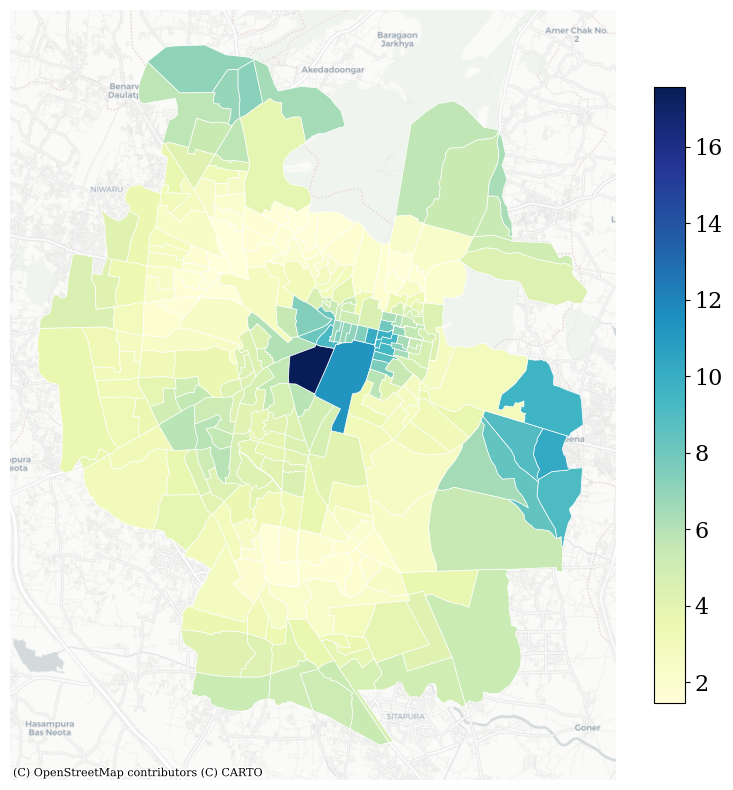

In [120]:
import contextily as cx

# Create figure and axes
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Set white background
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Ensure GeoDataFrame uses Web Mercator projection (EPSG:3857)
if ward_results.crs != 'EPSG:3857':
    ward_results_projected = ward_results.to_crs('EPSG:3857')
else:
    ward_results_projected = ward_results.copy()

# Plot the map with YlGnBu color scheme
ward_results_projected.plot(column='mgwrCN',
                           cmap='YlGnBu',  # Yellow-Green-Blue color scheme
                           legend=True,
                           ax=ax,
                           edgecolor='white',  # White boundary lines
                           linewidth=0.5,     # Thin boundary lines
                           alpha=1,         # Add transparency to see basemap
                           legend_kwds={'shrink': 0.8, 'aspect': 20})  # Adjust legend size

# Add CartoDB Positron basemap
try:
    cx.add_basemap(ax,
                   crs=ward_results_projected.crs,
                   source=cx.providers.CartoDB.Positron,
                   alpha=1)  # Basemap transparency
except Exception as e:
    print(f"Unable to add basemap: {e}")

# # Set title
# ax.set_title('CN Local Multicollinearity',
#              fontdict={'fontsize': 16, 'fontweight': 'normal'},
#              pad=20)

# Remove coordinate axes
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

# Remove coordinate axes borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Save with white background
plt.savefig('CN_local_multicollinearity.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec


# fig = plt.figure(figsize=(15, 10))
# gs = gridspec.GridSpec(2, 3, figure=fig)

# ax0 = fig.add_subplot(gs[0, 0])
# ax1 = fig.add_subplot(gs[0, 1])
# ax2 = fig.add_subplot(gs[0, 2])

# ax3 = fig.add_subplot(gs[1, 0])
# ax4 = fig.add_subplot(gs[1, 1])


# ax_list = [ax0, ax1, ax2, ax3]
# titles = ['Intercept', 'Illum_vol', 'Light_Intensity', 'Poi_Kde']


# for i, row in enumerate(filtered_estimates.T):
#     ct_temp = ward_results.assign(toplot=filtered_estimates.T[i])
#     ct_temp.query('toplot==0').plot(color='grey', ax=ax_list[i], alpha=0.2)
#     ct_temp.query('toplot!=0').plot('toplot', cmap='viridis', ax=ax_list[i], legend=True)
#     ax_list[i].set_title(titles[i], fontsize=12)
#     ax_list[i].axis('off')


# ward_results.assign(r2=ward_results.localR2).plot(
#     'r2', ax=ax4, cmap='Reds', vmin=0, vmax=1, legend=True
# )
# ax4.set_title('Local pDev', fontsize=12)
# ax4.axis('off')


# plt.tight_layout()
# plt.savefig('gwr_layout_clean.png')
# plt.show()



In [ ]:
ward_results.columns

In [ ]:
ward_results.drop(columns=['mgwrCN'], inplace=True)

In [ ]:
# exporet ward_results.gdf as a geojson file


In [ ]:
ward_results.to_file("ward_results_mgwr_03.geojson", driver='GeoJSON')